# 1 Linear Regression With Time Series

In [1]:
import pandas as pd

df = pd.read_csv(
    "book_sales.csv",
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


Doğrusal regrasyon formülü;

```
target = weight_1 * feature_1 + weight_2 * feature_2 + bias
```

In [2]:
import numpy as np
df['Time'] = np.arange(len(df.index))
df.head()

,Hardcover,Time
Date,,
2000-04-01,139,0
2000-04-02,128,1
2000-04-03,172,2
2000-04-04,139,3
2000-04-05,191,4


Time dummy ile doğrusal regresyon modeli üretir:

```
target = weight * time + bias
```

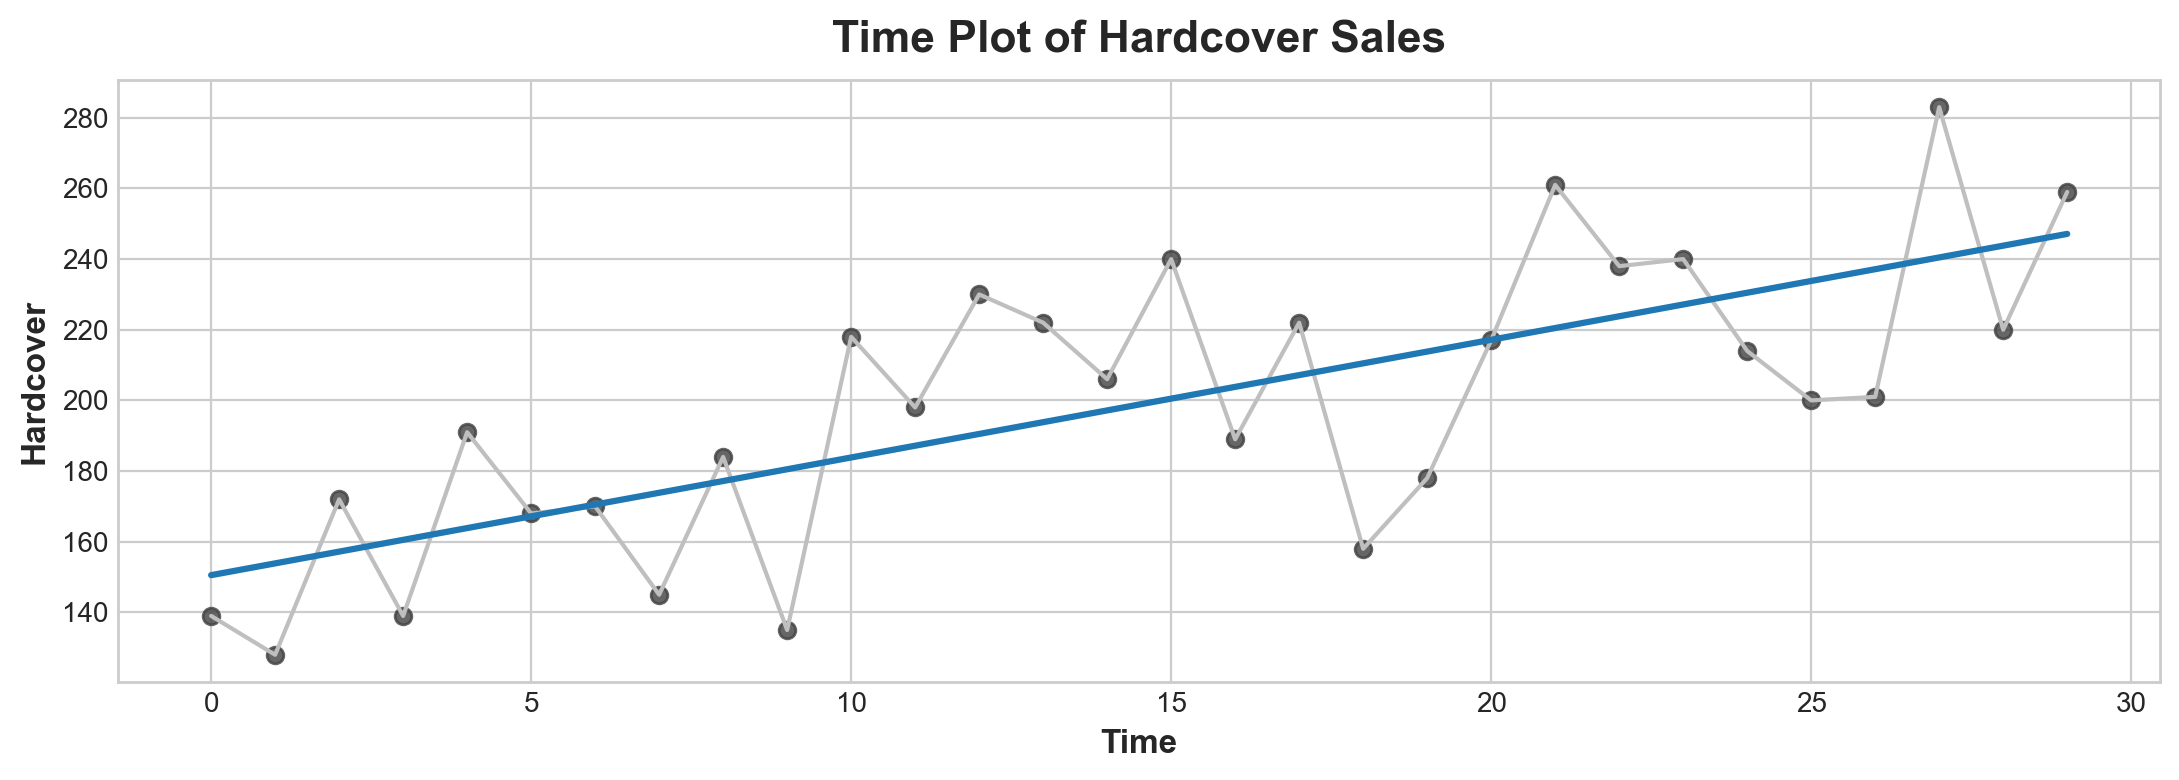

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

In [4]:
# Bir adım yerine daha fazla adımlı da oluşturabiliriz
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])
df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


Gecikme özelliğine sahip doğrusal regresyon formulü:

```
target = weight * lag + bias
```

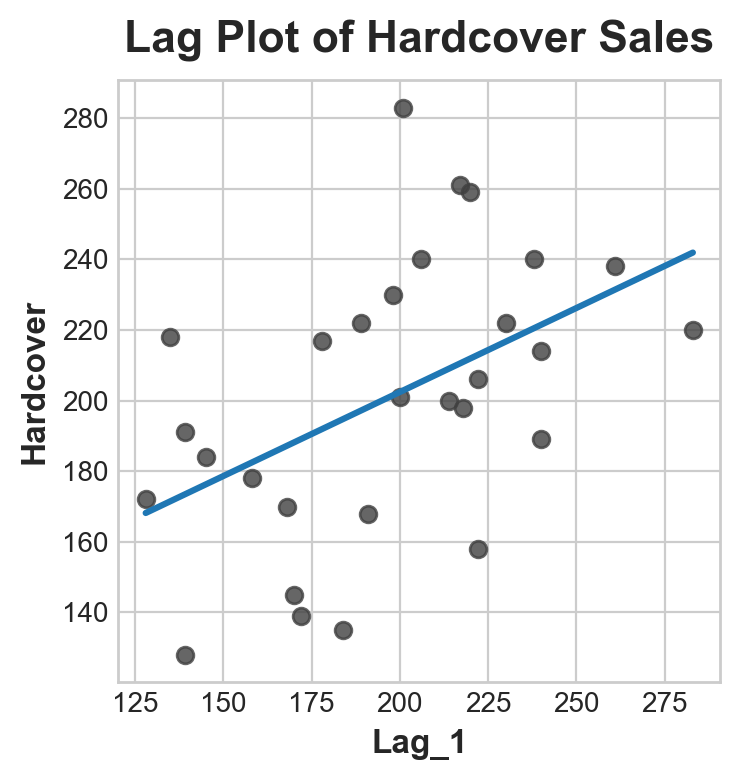

In [5]:

fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

## Example - Tunnel Traffic

In [6]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
tunnel = pd.read_csv("tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

tunnel.head()

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569


### Time-step feature

In [7]:
# Zaman serisinin eksik tarihi olmaması koşuluyla, serinin uzunluğunu sayarak bir time dummy oluşturabiliriz.
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index))

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


In [8]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

Aslında oluşturulan model (yaklaşık olarak): `Vehicles = 22.5 * Time + 98176`

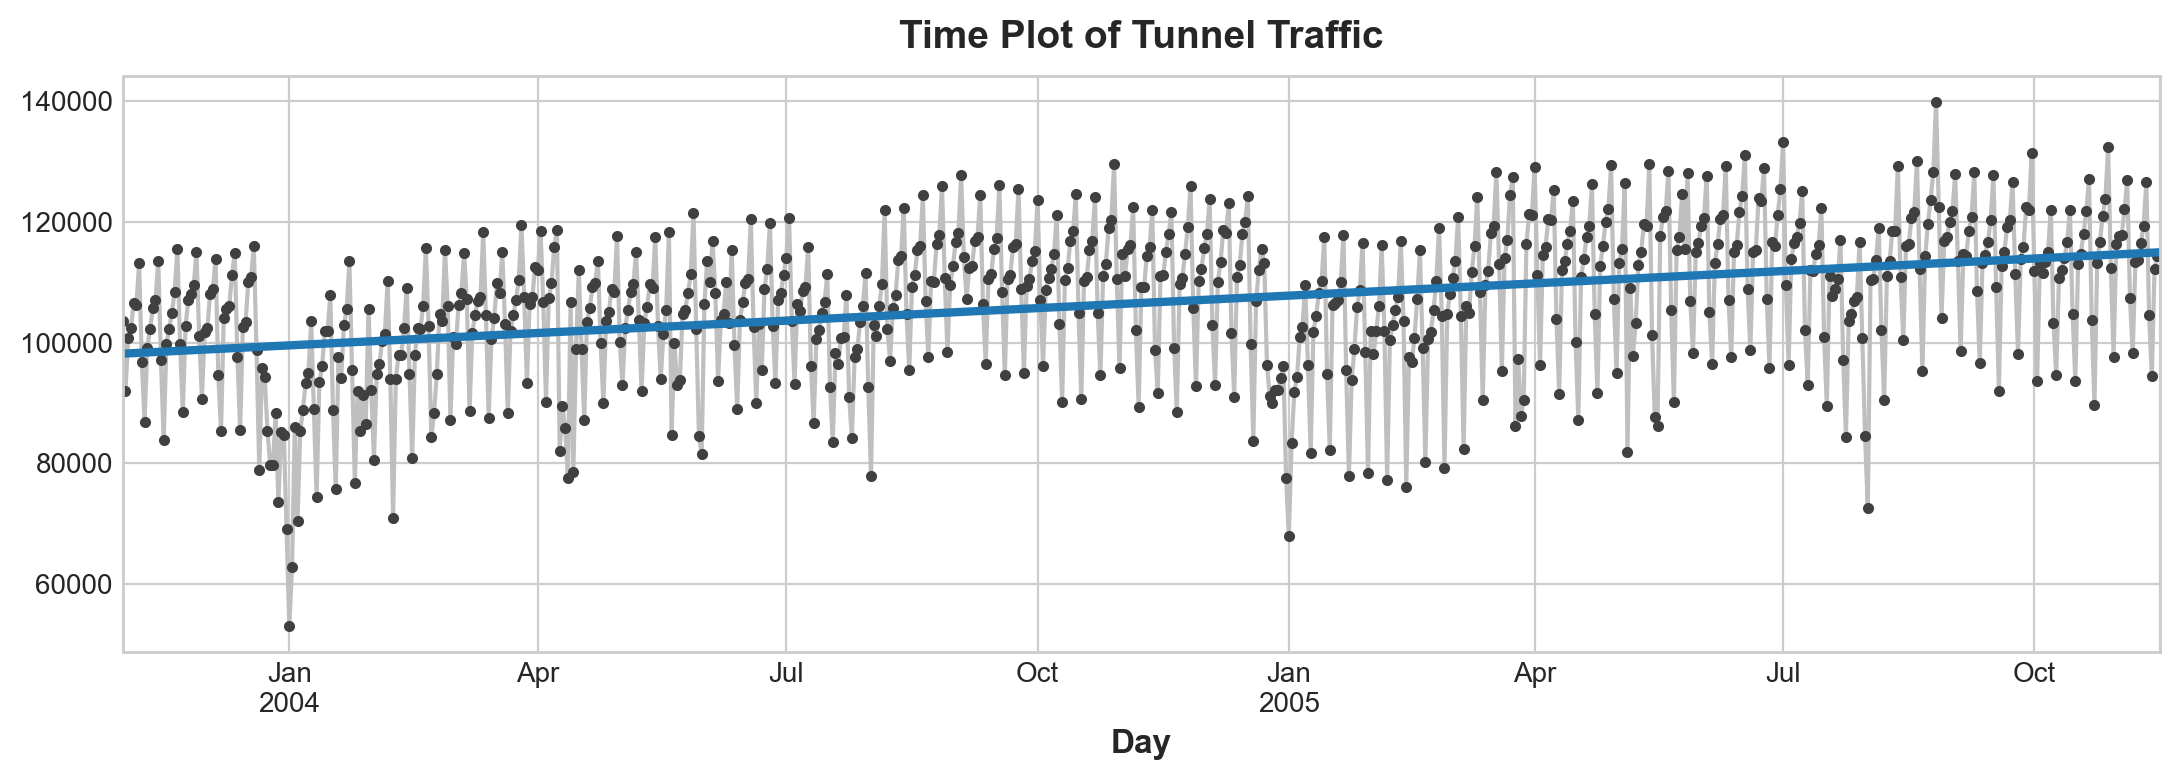

In [9]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

### Lag feature

In [10]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


In [11]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

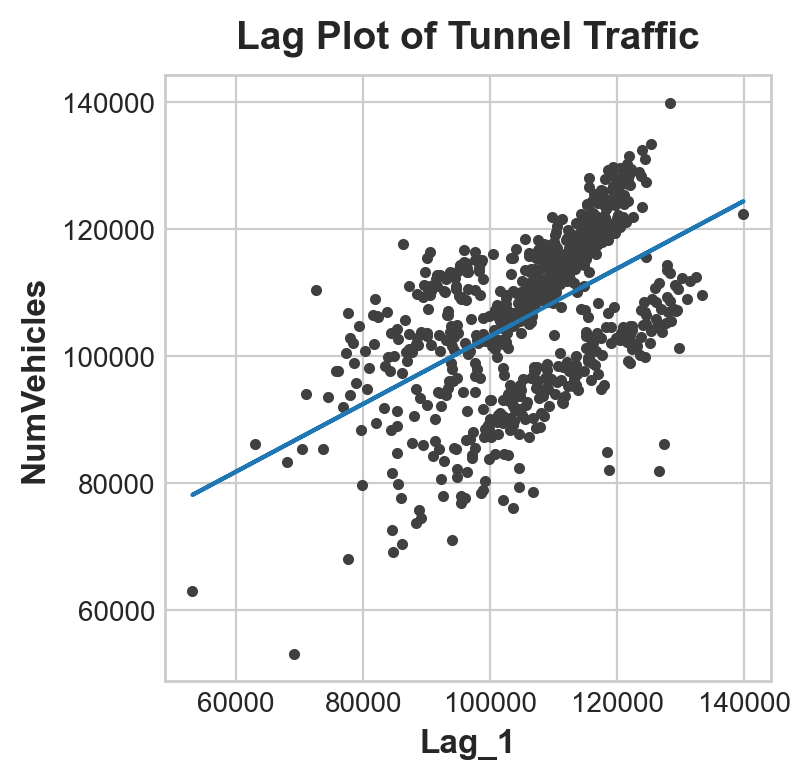

In [12]:

fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

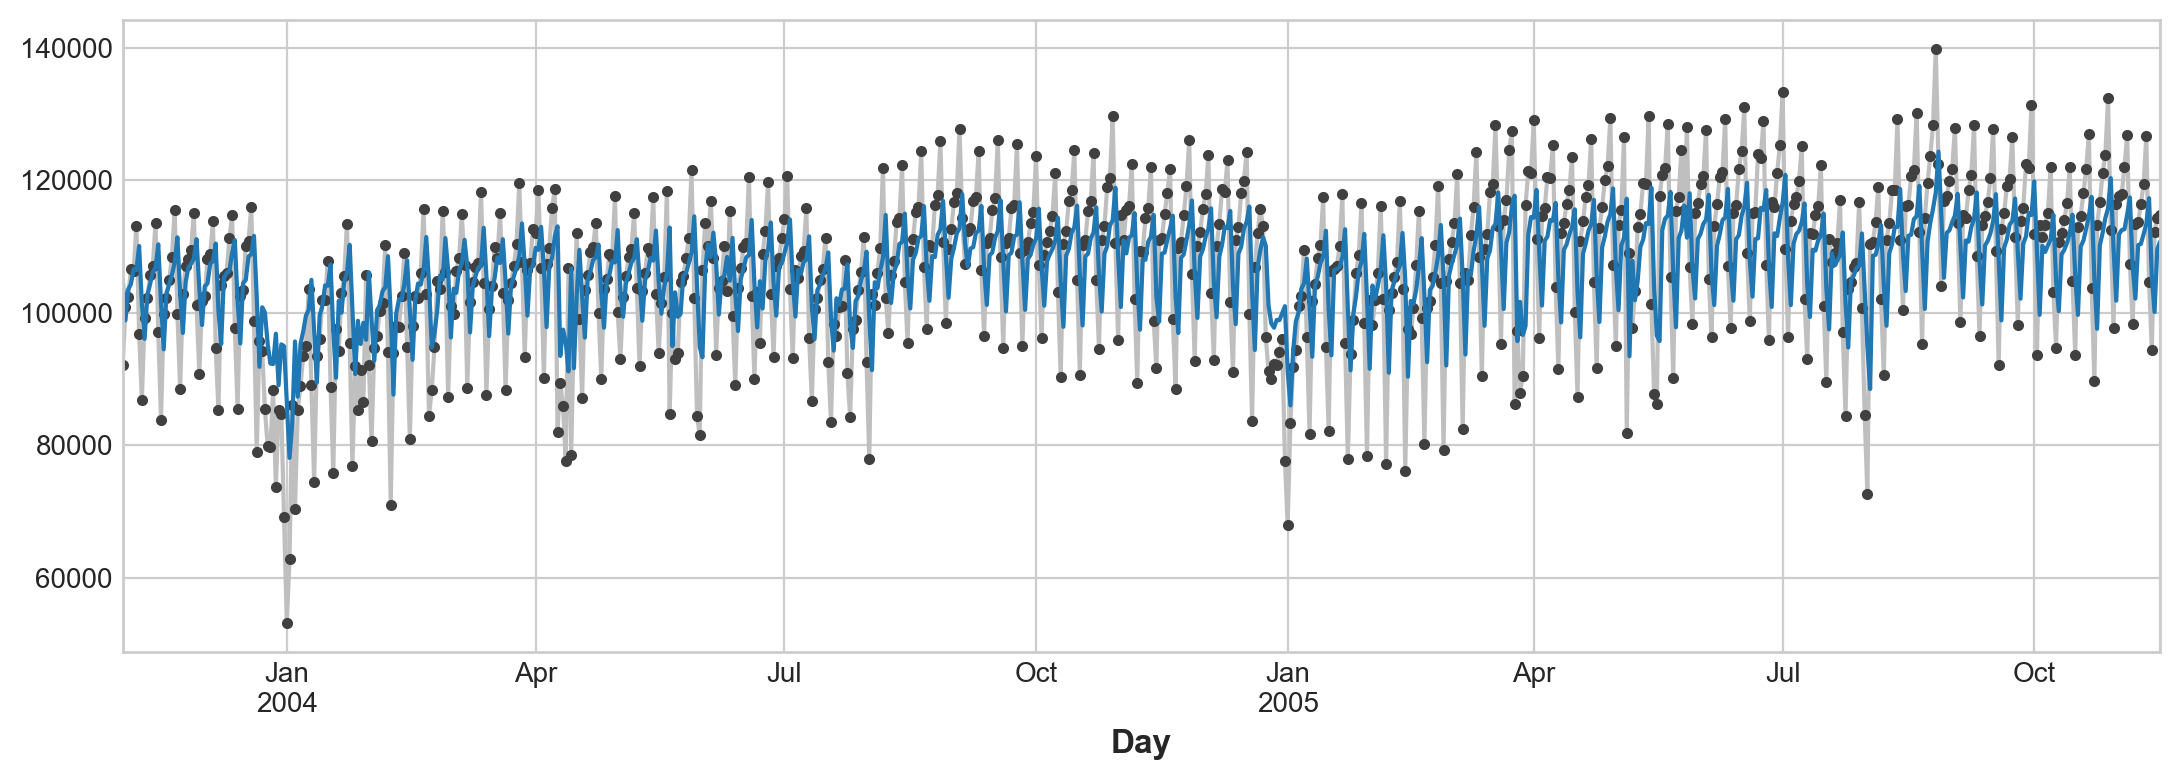

In [13]:

ax = y.plot(**plot_params)
ax = y_pred.plot()

---

# 2 Trend?

The **trend** component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/ZdS4ZoJ.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Trend patterns in four time series.</center></figcaption>
</figure>

In this course, we'll focus on trends in the mean. More generally though, any persistent and slow-moving change in a series could constitute a trend -- time series commonly have trends in their variation for instance.

# Moving Average Plots #

To see what kind of trend a time series might have, we can use a **moving average plot**. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/EZOXiPs.gif" width=800, alt="An animated plot showing an undulating curve slowly increasing with a moving average line developing from left to right within a window of 12 points (in red).">
<figcaption style="textalign: center; font-style: italic"><center>A moving average plot illustrating a linear trend. Each point on the curve (blue) is the average of the points (red) within a window of size 12.
</center></figcaption>
</figure>

Notice how the *Mauna Loa* series above has a repeating up and down movement year after year -- a short-term, *seasonal* change. For a change to be a part of the trend, it should occur over a longer period than any seasonal changes. To visualize a trend, therefore, we take an average over a period longer than any seasonal period in the series. For the *Mauna Loa* series, we chose a window of size 12 to smooth over the season within each year.

# Engineering Trend #

Once we've identified the shape of the trend, we can attempt to model it using a time-step feature. We've already seen how using the time dummy itself will model a linear trend:

```
target = a * time + b
```

We can fit many other kinds of trend through transformations of the time dummy. If the trend appears to be quadratic (a parabola), we just need to add the square of the time dummy to the feature set, giving us:
```
target = a * time ** 2 + b * time + c
```
Linear regression will learn the coefficients `a`, `b,` and `c`.

The trend curves in the figure below were both fit using these kinds of features and scikit-learn's `LinearRegression`:

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/KFYlgGm.png" width=*00, alt="Above, Cars Sold in Quebec: an undulating plot gradually increasing from 1960-01 to 1968-12 with a linear trend-line superimposed. Below, Plastics Production in Australia: an undulating plot with a concave-up quadratic trend-line superimposed.">
<figcaption style="textalign: center; font-style: italic"><center><strong>Top:</strong> Series with a linear trend. <strong>Below:</strong> Series with a quadratic trend.
</center></figcaption>
</figure>

If you haven't seen the trick before, you may not have realized that linear regression can fit curves other than lines. The idea is that if you can provide curves of the appropriate shape as features, then linear regression can learn how to combine them in the way that best fits the target.

# Example - Tunnel Traffic #

In this example we'll create a trend model for the *Tunnel Traffic* dataset.

In [14]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("../input/ts-course-data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

OSError: 'seaborn-whitegrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

Let's make a moving average plot to see what kind of trend this series has. Since this series has daily observations, let's choose a window of 365 days to smooth over any short-term changes within the year.

To create a moving average, first use the `rolling` method to begin a windowed computation. Follow this by the `mean` method to compute the average over the window. As we can see, the trend of *Tunnel Traffic* appears to be about linear.

In [ ]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

In Lesson 1, we engineered our time dummy in Pandas directly. From now on, however, we'll use a function from the `statsmodels` library called `DeterministicProcess`. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The `order` argument refers to polynomial order: `1` for linear, `2` for quadratic, `3` for cubic, and so on.

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

(A *deterministic process*, by the way, is a technical term for a time series that is non-random or completely *determined*, like the `const` and `trend` series are. Features derived from the time index will generally be deterministic.)

We create our trend model basically as before, though note the addition of the `fit_intercept=False` argument.

In [ ]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

The trend discovered by our `LinearRegression` model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.

In [ ]:

ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [ ]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

Let's plot a portion of the series to see the trend forecast for the next 30 days:

In [ ]:

ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

---

The trend models we learned about in this lesson turn out to be useful for a number of reasons. Besides acting as a baseline or starting point for more sophisticated models, we can also use them as a component in a "hybrid model" with algorithms unable to learn trends (like XGBoost and random forests). We'll learn more about this technique in Lesson 5.

# Your Turn #

[**Model trend in Store Sales**](https://www.kaggle.com/kernels/fork/19616015) and understand the risks of forecasting with high-order polynomials.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*

# 3 Seasonality

We say that a time series exhibits **seasonality** whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/ViYbSxS.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Seasonal patterns in four time series.
</center></figcaption>
</figure>

We will learn two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.

# Seasonal Plots and Seasonal Indicators #

Just like we used a moving average plot to discover the trend in a series, we can use a **seasonal plot** to discover seasonal patterns.

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. The figure shows a seasonal plot of the daily views of Wikipedia's article on *Trigonometry*: the article's daily views plotted over a common *weekly* period.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/bd7D4NJ.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>There is a clear weekly seasonal pattern in this series, higher on weekdays and falling towards the weekend.
</center></figcaption>
</figure>

### Seasonal indicators

**Seasonal indicators** are binary features that represent seasonal differences in the level of a time series. Seasonal indicators are what you get if you treat a seasonal period as a categorical feature and apply one-hot encoding.

By one-hot encoding days of the week, we get weekly seasonal indicators. Creating weekly indicators for the *Trigonometry* series will then give us six new "dummy" features. (Linear regression works best if you drop one of the indicators; we chose Monday in the frame below.)

| Date       | Tuesday | Wednesday | Thursday | Friday | Saturday | Sunday |
|------------|---------|-----------|----------|--------|----------|--------|
| 2016-01-04 | 0.0     | 0.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-05 | 1.0     | 0.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-06 | 0.0     | 1.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-07 | 0.0     | 0.0       | 1.0      | 0.0    | 0.0      | 0.0    |
| 2016-01-08 | 0.0     | 0.0       | 0.0      | 1.0    | 0.0      | 0.0    |
| 2016-01-09 | 0.0     | 0.0       | 0.0      | 0.0    | 1.0      | 0.0    |
| 2016-01-10 | 0.0     | 0.0       | 0.0      | 0.0    | 0.0      | 1.0    |
| 2016-01-11 | 0.0     | 0.0       | 0.0      | 0.0    | 0.0      | 0.0    |
| ...        | ...     | ...       | ...      | ...    | ...      | ...    |

Adding seasonal indicators to the training data helps models distinguish means within a seasonal period:

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/hIlF5j5.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Ordinary linear regression learns the mean values at each time in the season.</center></figcaption>
</figure>

The indicators act as On / Off switches. At any time, at most one of these indicators can have a value of `1` (*On*). Linear regression learns a baseline value `2379` for `Mon` and then adjusts by the value of whichever indicator is *On* for that day; the rest are `0` and vanish.

# Fourier Features and the Periodogram #

The kind of feature we discuss now are better suited for long seasons over many observations where indicators would be impractical. Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

Let's take a look at a plot for the annual season in *Trigonometry*. Notice the repetitions of various frequencies: a long up-and-down movement three times a year, short weekly movements 52 times a year, and perhaps others.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/NJcaEdI.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Annual seasonality in the <em>Wiki Trigonometry</em> series.</center></figcaption>
</figure>

It is these frequencies within a season that we attempt to capture with Fourier features. The idea is to include in our training data periodic curves having the same frequencies as the season we are trying to model. The curves we use are those of the trigonometric functions sine and cosine.

**Fourier features** are pairs of sine and cosine curves, one pair for each potential frequency in the season starting with the longest. Fourier pairs modeling annual seasonality would have frequencies: once per year, twice per year, three times per year, and so on.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/bKOjdU7.png" width=600, alt="A top figure and a bottom figure, each showing a sine curve and a cosine curve. The curves in the top plot both have frequency of once per year, while the curves in the bottom plot both have a frequency of twice per year.">
<figcaption style="textalign: center; font-style: italic"><center>The first two Fourier pairs for annual seasonality. <strong>Top: </strong>Frequency of once per year. <strong>Bottom: </strong>Frequency of twice per year.</strong></center></figcaption>
</figure>

If we add a set of these sine / cosine curves to our training data, the linear regression algorithm will figure out the weights that will fit the seasonal component in the target series. The figure illustrates how linear regression used four Fourier pairs to model the annual seasonality in the *Wiki Trigonometry* series.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/mijPhko.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center><strong>Top: </strong>Curves for four Fourier pairs, a sum of sine and cosine with regression coefficients. Each curve models a different frequency. <strong>Bottom: </strong>The sum of these curves approximates the seasonal pattern.</center></figcaption>
</figure>

Notice that we only needed eight features (four sine / cosine pairs) to get a good estimate of the annual seasonality. Compare this to the seasonal indicator method which would have required hundreds of features (one for each day of the year). By modeling only the "main effect" of the seasonality with Fourier features, you'll usually need to add far fewer features to your training data, which means reduced computation time and less risk of overfitting.

### Choosing Fourier features with the Periodogram

How many Fourier pairs should we actually include in our feature set? We can answer this question with the periodogram. The **periodogram** tells you the strength of the frequencies in a time series. Specifically, the value on the y-axis of the graph is `(a ** 2 + b ** 2) / 2`, where `a` and `b` are the coefficients of the sine and cosine at that frequency (as in the *Fourier Components* plot above).

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/PK6WEe3.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Periodogram for the <em>Wiki Trigonometry</em> series.</center></figcaption>
</figure>

From left to right, the periodogram drops off after *Quarterly*, four times a year. That was why we chose four Fourier pairs to model the annual season. The *Weekly* frequency we ignore since it's better modeled with indicators.

### Computing Fourier features (optional)

Knowing how Fourier features are computed isn't essential to using them, but if seeing the details would clarify things, the cell hidden cell below illustrates how a set of Fourier features could be derived from the index of a time series. (We'll use a library function from `statsmodels` for our applications, however.)

In [ ]:

import numpy as np


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
# fourier_features(y, freq=365.25, order=4)

# Example - Tunnel Traffic #

We'll continue once more with the *Tunnel Traffic* dataset. This hidden cell loads the data and defines two functions: `seasonal_plot` and `plot_periodogram`.

In [ ]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


data_dir = Path("../input/ts-course-data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

Let's take a look at seasonal plots over a week and over a year.

In [ ]:
X = tunnel.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

Now let's look at the periodogram:

In [ ]:
plot_periodogram(tunnel.NumVehicles);

The periodogram agrees with the seasonal plots above: a strong weekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between *Bimonthly (6)* and *Monthly (12)*, so let's use 10 Fourier pairs.

We'll create our seasonal features using `DeterministicProcess`, the same utility we used in Lesson 2 to create trend features. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

With our feature set created, we're ready to fit the model and make predictions. We'll add a 90-day forecast to see how our model extrapolates beyond the training data. The code here is the same as that in earlier lessons.

In [ ]:

y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

---

There's still more we can do with time series to improve our forecasts. In the next lesson, we'll learn how to use time series themselves as a features. Using time series as inputs to a forecast lets us model the another component often found in series: *cycles*.

# Your Turn #

[**Create seasonal features for Store Sales**](https://www.kaggle.com/kernels/fork/19615991) and extend these techniques to capturing holiday effects.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*


# 4 Time Series as Features

In earlier lessons, we investigated properties of time series that were most easily modeled as *time dependent* properties, that is, with features we could derive directly from the time index. Some time series properties, however, can only be modeled as *serially dependent* properties, that is, using as features past values of the target series. The structure of these time series may not be apparent from a plot over time; plotted against past values, however, the structure becomes clear -- as we see in the figure below below.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/X0sSnwp.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>These two series have serial dependence, but not time dependence. Points on the right have coordinates <code>(value at time t-1, value at time t)</code>.
</center></figcaption>
</figure>

With trend and seasonality, we trained models to fit curves to plots like those on the left in the figure above -- the models were learning time dependence. The goal in this lesson is to train models to fit curves to plots like those on the right -- we want them to learn serial dependence.

### Cycles

One especially common way for serial dependence to manifest is in **cycles**. Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself.  Cyclic behavior is characteristic of systems that can affect themselves or whose reactions persist over time. Economies, epidemics, animal populations, volcano eruptions, and similar natural phenomena often display cyclic behavior.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/CC3TkAf.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Four time series with cyclic behavior.
</center></figcaption>
</figure>

What distinguishes cyclic behavior from seasonality is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurence, and more about what has happened in the recent past. The (at least relative) independence from time means that cyclic behavior can be much more irregular than seasonality.

# Lagged Series and Lag Plots #

To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series. **Lagging** a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time.

This shows the monthly unemployment rate in the US (`y`) together with its first and second lagged series (`y_lag_1` and `y_lag_2`, respectively). Notice how the values of the lagged series are shifted forward in time.

In [ ]:

import pandas as pd

# Federal Reserve dataset: https://www.kaggle.com/federalreserve/interest-rates
reserve = pd.read_csv(
    "../input/ts-course-data/reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df.head()

By lagging a time series, we can make its past values appear contemporaneous with the values we are trying to predict (in the same row, in other words). This makes lagged series useful as features for modeling serial dependence. To forecast the US unemployment rate series, we could use `y_lag_1` and `y_lag_2` as features to predict the target `y`. This would forecast the future unemployment rate as a function of the unemployment rate in the prior two months.

### Lag plots

A **lag plot** of a time series shows its values plotted against its lags. Serial dependence in a time series will often become apparent by looking at a lag plot. We can see from this lag plot of *US Unemployment* that there is a strong and apparently linear relationship between the current unemployment rate and past rates.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Hvrboya.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Lag plot of US Unemployment with autocorrelations indicated.
</center></figcaption>
</figure>

The most commonly used measure of serial dependence is known as **autocorrelation**, which is simply the correlation a time series has with one of its lags. *US Unemployment* has an autocorrelation of 0.99 at lag 1, 0.98 at lag 2, and so on.

### Choosing lags

When choosing lags to use as features, it generally won't be useful to include *every* lag with a large autocorrelation. In *US Unemployment*, for instance, the autocorrelation at lag 2 might result entirely from "decayed" information from lag 1 -- just correlation that's carried over from the previous step. If lag 2 doesn't contain anything new, there would be no reason to include it if we already have lag 1.

The **partial autocorrelation** tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak. Plotting the partial autocorrelation can help you choose which lag features to use. In the figure below, lag 1 through lag 6 fall outside the intervals of "no correlation" (in blue), so we might choose lags 1 through lag 6 as features for *US Unemployment*. (Lag 11 is likely a false positive.)

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/6nTe94E.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Partial autocorrelations of US Unemployment through lag 12 with 95% confidence intervals of no correlation.
</center></figcaption>
</figure>

A plot like that above is known as a *correlogram*. The correlogram is for lag features essentially what the periodogram is for Fourier features.

Finally, we need to be mindful that autocorrelation and partial autocorrelation are measures of *linear* dependence. Because real-world time series often have substantial non-linear dependences, it's best to look at a lag plot (or use some more general measure of dependence, like [mutual information](https://www.kaggle.com/ryanholbrook/mutual-information)) when choosing lag features. The *Sunspots* series has lags with non-linear dependence which we might overlook with autocorrelation.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Q38UVOu.png" width=350, alt="">
    <figcaption style="textalign: center; font-style: italic"><center>Lag plot of the <em>Sunspots</em> series.
</center></figcaption>
</figure>

Non-linear relationships like these can either be transformed to be linear or else learned by an appropriate algorithm.

# Example - Flu Trends #

The *Flu Trends* dataset contains records of doctor's visits for the flu for weeks between 2009 and 2016. Our goal is to forecast the number of flu cases for the coming weeks.

We will take two approaches. In the first we'll forecast doctor's visits using lag features. Our second approach will be to forecast doctor's visits using lags of *another* set of time series: flu-related search terms as captured by Google Trends.

In [ ]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


data_dir = Path("../input/ts-course-data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

Our *Flu Trends* data shows irregular cycles instead of a regular seasonality: the peak tends to occur around the new year, but sometimes earlier or later, sometimes larger or smaller. Modeling these cycles with lag features will allow our forecaster to react dynamically to changing conditions instead of being constrained to exact dates and times as with seasonal features.

Let's take a look at the lag and autocorrelation plots first:

In [ ]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

The lag plots indicate that the relationship of `FluVisits` to its lags is mostly linear, while the partial autocorrelations suggest the dependence can be captured using lags 1, 2, 3, and 4. We can lag a time series in Pandas with the `shift` method. For this problem, we'll fill in the missing values the lagging creates with `0.0`.

In [ ]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

In previous lessons, we were able to create forecasts for as many steps as we liked beyond the training data. When using lag features, however, we are limited to forecasting time steps whose lagged values are available. Using a lag 1 feature on Monday, we can't make a forecast for Wednesday because the lag 1 value needed is Tuesday which hasn't happened yet.

We'll see strategies for handling this problem in Lesson 6. For this example, we'll just use a values from a test set.

In [ ]:

# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

In [ ]:

ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

---

Looking just at the forecast values, we can see how our model needs a time step to react to sudden changes in the target series. This is a common limitation of models using only lags of the target series as features.

In [ ]:

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

To improve the forecast we could try to find *leading indicators*, time series that could provide an "early warning" for changes in flu cases. For our second approach then we'll add to our training data the popularity of some flu-related search terms as measured by Google Trends.

Plotting the search phrase `'FluCough'` against the target `'FluVisits'` suggests such search terms could be useful as leading indicators: flu-related searches tend to become more popular in the weeks prior to office visits.

In [ ]:

ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

The dataset contains 129 such terms, but we'll just use a few.

In [ ]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)
X0.columns = [' '.join(col).strip() for col in X0.columns.values]

# Create four lags for the target, as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

Our forecasts are a bit rougher, but our model appears to be better able to anticipate sudden increases in flu visits, suggesting that the several time series of search popularity were indeed effective as leading indicators.

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

---

The time series illustrated in this lesson are what you might call "purely cyclic": they have no obvious trend or seasonality. It's not uncommon though for time series to possess trend, seasonality, and cycles -- all three components at once. You could model such series with linear regression by just adding the appropriate features for each component. You can even combine models trained to learn the components separately, which we'll learn how to do in the next lesson with *forecasting hybrids*.

# Your Turn #

[**Create lag features for Store Sales**](https://www.kaggle.com/kernels/fork/19616002) and explore other kinds of time series features.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*


# 5 Hybrid Models

Linear regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends. In this lesson, we'll learn how to create "hybrid" forecasters that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other. 

# Components and Residuals #

So that we can design effective hybrids, we need a better understanding of how time series are constructed. We've studied up to now three patterns of dependence: trend, seasons, and cycles. Many time series can be closely described by an additive model of just these three components plus some essentially unpredictable, entirely random *error*:

```
series = trend + seasons + cycles + error
```

Each of the terms in this model we would then call a **component** of the time series.

The **residuals** of a model are the difference between the target the model was trained on and the predictions the model makes -- the difference between the actual curve and the fitted curve, in other words. Plot the residuals against a feature, and you get the "left over" part of the target, or what the model failed to learn about the target from that feature.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/mIeeaBD.png" width=700, alt="">
<figcaption style="textalign: center; font-style: italic"><center>The difference between the target series and the predictions (blue) gives the series of residuals.
</center></figcaption>
</figure>

On the left of the figure above is a portion of the *Tunnel Traffic* series and the trend-seasonal curve from Lesson 3. Subtracting out the fitted curve leaves the residuals, on the right. The residuals contain everything from *Tunnel Traffic* the trend-seasonal model didn't learn.

We could imagine learning the components of a time series as an iterative process: first learn the trend and subtract it out from the series, then learn the seasonality from the detrended residuals and subtract the seasons out, then learn the cycles and subtract the cycles out, and finally only the unpredictable error remains.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/XGJuheO.png" width=700, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Learning the components of <em>Mauna Loa CO2</em> step by step. Subtract the fitted curve (blue) from its series to get the series in the next step.
</center></figcaption>
</figure>

Add together all the components we learned and we get the complete model. This is essentially what linear regression would do if you trained it on a complete set of features modeling trend, seasons, and cycles.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/HZEhuHF.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Add the learned components to get a complete model.
</center></figcaption>
</figure>

# Hybrid Forecasting with Residuals #

In previous lessons, we used a single algorithm (linear regression) to learn all the components at once. But it's also possible to use one algorithm for some of the components and another algorithm for the rest. This way we can always choose the best algorithm for each component. To do this, we use one algorithm to fit the original series and then the second algorithm to fit the residual series.

In detail, the process is this:
```
# 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2
```

We'll usually want to use different feature sets (`X_train_1` and `X_train_2` above) depending on what we want each model to learn. If we use the first model to learn the trend, we generally wouldn't need a trend feature for the second model, for example.

While it's possible to use more than two models, in practice it doesn't seem to be especially helpful. In fact, the most common strategy for constructing hybrids is the one we've just described: a simple (usually linear) learning algorithm followed by a complex, non-linear learner like GBDTs or a deep neural net, the simple model typically designed as a "helper" for the powerful algorithm that follows.

### Designing Hybrids

There are many ways you could combine machine learning models besides the way we've outlined in this lesson. Successfully combining models, though, requires that we dig a bit deeper into how these algorithms operate.

There are generally two ways a regression algorithm can make predictions: either by transforming the *features* or by transforming the *target*. Feature-transforming algorithms learn some mathematical function that takes features as an input and then combines and transforms them to produce an output that matches the target values in the training set. Linear regression and neural nets are of this kind.

Target-transforming algorithms use the features to group the target values in the training set and make predictions by averaging values in a group; a set of feature just indicates which group to average. Decision trees and nearest neighbors are of this kind.

The important thing is this: feature transformers generally can **extrapolate** target values beyond the training set given appropriate features as inputs, but the predictions of target transformers will always be bound within the range of the training set. If the time dummy continues counting time steps, linear regression continues drawing the trend line. Given the same time dummy, a decision tree will predict the trend indicated by the last step of the training data into the future forever. *Decision trees cannot extrapolate trends.* Random forests and gradient boosted decision trees (like XGBoost) are ensembles of decision trees, so they also cannot extrapolate trends.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/ZZtfuFJ.png" width=600, alt="">
<figcaption style="textalign: center; font-style: italic"><center>A decision tree will fail to extrapolate a trend beyond the training set.
</center></figcaption>
</figure>

This difference is what motivates the hybrid design in this lesson: use linear regression to extrapolate the trend, transform the *target* to remove the trend, and apply XGBoost to the detrended residuals. To hybridize a neural net (a feature transformer), you could instead include the predictions of another model as a feature, which the neural net would then include as part of its own predictions. The method of fitting to residuals is actually the same method the gradient boosting algorithm uses, so we will call these **boosted** hybrids; the method of using predictions as features is known as "stacking", so we will call these **stacked** hybrids.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
<strong>Winning Hybrids from Kaggle Competitions</strong>
    <p>For inspiration, here are a few top scoring solutions from past competitions:</p>
<ul>
    <li><a href="https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/discussion/8125">STL boosted with exponential smoothing</a> - Walmart Recruiting - Store Sales Forecasting</li>
    <li><a href="https://www.kaggle.com/c/rossmann-store-sales/discussion/17896">ARIMA and exponential smoothing boosted with GBDT</a> - Rossmann Store Sales</li> 
    <li><a href="https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/39395">An ensemble of stacked and boosted hybrids</a> - Web Traffic Time Series Forecasting</li>
    <li><a href="https://github.com/Mcompetitions/M4-methods/blob/slaweks_ES-RNN/118%20-%20slaweks17/ES_RNN_SlawekSmyl.pdf">Exponential smoothing stacked with LSTM neural net</a> - M4 (non-Kaggle)</li>
</ul>
</blockquote>

# Example - US Retail Sales #

The [*US Retail Sales*](https://www.census.gov/retail/index.html) dataset contains monthly sales data for various retail industries from 1992 to 2019, as collected by the US Census Bureau. Our goal will be to forecast sales in the years 2016-2019 given sales in the earlier years. In addition to creating a linear regression + XGBoost hybrid, we'll also see how to set up a time series dataset for use with XGBoost.

In [ ]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor


simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

data_dir = Path("../input/ts-course-data/")
industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    usecols=['Month'] + industries,
    parse_dates=['Month'],
    index_col='Month',
).to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

First let's use a linear regression model to learn the trend in each series. For demonstration, we'll use a quadratic (order 2) trend. (The code here is basically the same as that in previous lessons.) Though the fit isn't perfect, it will be enough for our needs.

In [ ]:

y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=2,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)
X = dp.in_sample()  # features for the training data

# Test on the years 2016-2019. It will be easier for us later if we
# split the date index instead of the dataframe directly.
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

While the linear regression algorithm is capable of multi-output regression, the XGBoost algorithm is not. To predict multiple series at once with XGBoost, we'll instead convert these series from *wide* format, with one time series per column, to *long* format, with series indexed by categories along rows.

In [ ]:
# The `stack` method converts column labels to row labels, pivoting from wide format to long
X = retail.stack()  # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')  # grab target series

So that XGBoost can learn to distinguish our two time series, we'll turn the row labels for `'Industries'` into a categorical feature with a label encoding. We'll also create a feature for annual seasonality by pulling the month numbers out of the time index.

In [ ]:
# Turn row labels into categorical feature columns with a label encoding
X = X.reset_index('Industries')
# Label encoding for 'Industries' feature
for colname in X.select_dtypes(["object", "category"]):
    X[colname], _ = X[colname].factorize()

# Label encoding for annual seasonality
X["Month"] = X.index.month  # values are 1, 2, ..., 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

Now we'll convert the trend predictions made earlier to long format and then subtract them from the original series. That will give us detrended (residual) series that XGBoost can learn.

In [ ]:
# Pivot wide to long (stack) and convert DataFrame to Series (squeeze)
y_fit = y_fit.stack().squeeze()    # trend from training set
y_pred = y_pred.stack().squeeze()  # trend from test set

# Create residuals (the collection of detrended series) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residuals onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

The fit appears quite good, though we can see how the trend learned by XGBoost is only as good as the trend learned by the linear regression -- in particular, XGBoost wasn't able to compensate for the poorly fit trend in the `'BuildingMaterials'` series.

In [ ]:

axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage'],
)
axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)
for ax in axs: ax.legend([])

# Your Turn #

[**Forecast Store Sales**](https://www.kaggle.com/kernels/fork/19616007) with an XGBoost hybrid and try out other combinations of ML algorithms.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*

# 6 Forecasting With Machine Learning

In Lessons 2 and 3, we treated forecasting as a simple regression problem with all of our features derived from a single input, the time index. We could easily create forecasts for any time in the future by just generating our desired trend and seasonal features.

When we added lag features in Lesson 4, however, the nature of the problem changed. Lag features require that the lagged target value is known at the time being forecast. A lag 1 feature shifts the time series forward 1 step, which means you could forecast 1 step into the future but not 2 steps.

In Lesson 4, we just assumed that we could always generate lags up to the period we wanted to forecast (every prediction was for just one step forward, in other words). Real-world forecasting typically demands more than this, so in this lesson we'll learn how to make forecasts for a variety of situations.

# Defining the Forecasting Task #

There are two things to establish before designing a forecasting model:
- what information is available at the time a forecast is made (features), and,
- the time period during which you require forecasted values (target).

The **forecast origin** is time at which you are making a forecast. Practically, you might consider the forecast origin to be the last time for which you have training data for the time being predicted. Everything up to he origin can be used to create features.

The **forecast horizon** is the time for which you are making a forecast. We often describe a forecast by the number of time steps in its horizon: a "1-step" forecast or "5-step" forecast, say. The forecast horizon describes the target.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/xwEgcOk.png" width=500, alt="">
<figcaption style="textalign: center; font-style: italic"><center>A three-step forecast horizon with a two-step lead time, using four lag features. The figure represents what would be a single row of training data -- data for a single prediction, in other words.
</center></figcaption>
</figure>

The time between the origin and the horizon is the **lead time** (or sometimes *latency*) of the forecast. A forecast's lead time is described by the number of steps from origin to horizon: a "1-step ahead" or "3-step ahead" forecast, say. In practice, it may be necessary for a forecast to begin multiple steps ahead of the origin because of delays in data acquisition or processing.

# Preparing Data for Forecasting #

In order to forecast time series with ML algorithms, we need to transform the series into a dataframe we can use with those algorithms. (Unless, of course, you are only using deterministic features like trend and seasonality.)

We saw the first half of this process in Lesson 4 when we created a feature set out of lags. The second half is preparing the target. How we do this depends on the forecasting task.

Each row in a dataframe represents a single forecast. The time index of the row is the first time in the forecast horizon, but we arrange values for the entire horizon in the same row. For multistep forecasts, this means we are requiring a model to produce multiple outputs, one for each step.

In [ ]:

import numpy as np
import pandas as pd

N = 20
ts = pd.Series(
    np.arange(N),
    index=pd.period_range(start='2010', freq='A', periods=N, name='Year'),
    dtype=pd.Int8Dtype,
)

# Lag features
X = pd.DataFrame({
    'y_lag_2': ts.shift(2),
    'y_lag_3': ts.shift(3),
    'y_lag_4': ts.shift(4),
    'y_lag_5': ts.shift(5),
    'y_lag_6': ts.shift(6),    
})

# Multistep targets
y = pd.DataFrame({
    'y_step_3': ts.shift(-2),
    'y_step_2': ts.shift(-1),
    'y_step_1': ts,
})

data = pd.concat({'Targets': y, 'Features': X}, axis=1)

data.head(10).style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                   .set_properties(['Features'], **{'background-color': 'Lavender'})

The above illustrates how a dataset would be prepared similar to the *Defining a Forecast* figure: a three-step forecasting task with a two-step lead time using five lag features. The original time series is `y_step_1`. The missing values we could either fill-in or drop.

# Multistep Forecasting Strategies #

There are a number of strategies for producing the multiple target steps required for a forecast. We'll outline four common strategies, each with strengths and weaknesses.

### Multioutput model

Use a model that produces multiple outputs naturally. Linear regression and neural networks can both produce multiple outputs. This strategy is simple and efficient, but not possible for every algorithm you might want to use. XGBoost can't do this, for instance.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/uFsHiqr.png" width=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### Direct strategy

Train a separate model for each step in the horizon: one model forecasts 1-step ahead, another 2-steps ahead, and so on. Forecasting 1-step ahead is a different problem than 2-steps ahead (and so on), so it can help to have a different model make forecasts for each step. The downside is that training lots of models can be computationally expensive.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/HkolNMV.png" width=900, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### Recursive strategy

Train a single one-step model and use its forecasts to update the lag features for the next step. With the recursive method, we feed a model's 1-step forecast back in to that same model to use as a lag feature for the next forecasting step. We only need to train one model, but since errors will propagate from step to step, forecasts can be inaccurate for long horizons.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/sqkSFDn.png" width=300, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

### DirRec strategy

A combination of the direct and recursive strategies: train a model for each step and use forecasts from previous steps as *new* lag features. Step by step, each model gets an additional lag input. Since each model always has an up-to-date set of lag features, the DirRec strategy can capture serial dependence better than Direct, but it can also suffer from error propagation like Recursive.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/B7KAvAO.png" width=900, alt="">
<figcaption style="textalign: center; font-style: italic"><center>
</center></figcaption>
</figure>

# Example - Flu Trends #

In this example we'll apply the MultiOutput and Direct strategies to the *Flu Trends* data from Lesson 4, this time making true forecasts for multiple weeks beyond the training period.

We'll define our forecasting task to have an 8-week horizon with a 1-week lead time. In other words, we'll be forecasting eight weeks of flu cases starting with the following week.

The hidden cell sets up the example and defines a helper function `plot_multistep`.

In [ ]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


data_dir = Path("../input/ts-course-data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

First we'll prepare our target series (weekly office visits for the flu) for multistep forecasting. Once this is done, training and prediction will be very straightfoward.

In [ ]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()

# Shifting has created indexes that don't match. Only keep times for
# which we have both targets and features.
y, X = y.align(X, join='inner', axis=0)

### Multioutput model

We'll use linear regression as a MultiOutput strategy. Once we have our data prepared for multiple outputs, training and prediction is the same as always.

In [ ]:

# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Remember that a multistep model will produce a complete forecast for each instance used as input. There are 269 weeks in the training set and 90 weeks in the test set, and we now have an 8-step forecast for each of these weeks.

In [ ]:

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

### Direct strategy

XGBoost can't produce multiple outputs for regression tasks. But by applying the Direct reduction strategy, we can still use it to produce multi-step forecasts. This is as easy as wrapping it with scikit-learn's `MultiOutputRegressor`.

In [ ]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

XGBoost here is clearly overfitting on the training set. But on the test set it seems it was able to capture some of the dynamics of the flu season better than the linear regression model. It would likely do even better with some hyperparameter tuning.

In [ ]:

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

To use the DirRec strategy, you would only need to replace `MultiOutputRegressor` with another scikit-learn wrapper, `RegressorChain`. The Recursive strategy we would need to code ourselves.

# Your Turn #

[**Create a forecasting dataset**](https://www.kaggle.com/kernels/fork/20667477) for *Store Sales* and apply the DirRec strategy.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*